# Query for Spectraction Results in OGA

 work with Weakly_2022_39
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/10/31
- update : 2022/11/01


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/atmospec 	setup
drp_pipe              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/drp_pipe 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/eups 	setup
summit_utils          LOCAL:/home/d/dagoret/repos/repos_w_2022_39/summit_utils 	setup


In [2]:
! eups list -s lsst_distrib

   g0b29ad24fb+a10408d0bf 	current w_2022_39 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import pickle

In [6]:
from astropy.time import Time
import astropy.units as u

## Config

### Butler

In [7]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser

In [8]:
# path index for each month
DATE="20220912"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

### Spectractor

In [9]:
configmode = "PSF2DFFM"

### The collection

In [10]:
my_collection = "u/dagoret/spectro/noflat/empty~holo4/"+str(DATE)
datasetRefs = registry.queryDatasets(datasetType='spectraction', collections=my_collection, where= "instrument='LATISS'")

In [11]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Loop on exposures

In [12]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers



for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectraction', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    if i > 15:
        break

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022091200106}
visit...................: 2022091200106
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20220912/20221026T100113Z
{'day_obs': 20220912, 'seq_num': 106, 'detector': 0}
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022091200107}
visit...................: 2022091200107
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20220912/20221026T101538Z
{'day_obs': 20220912, 'seq_num': 107, 'detector': 0}
============= 

## Plot

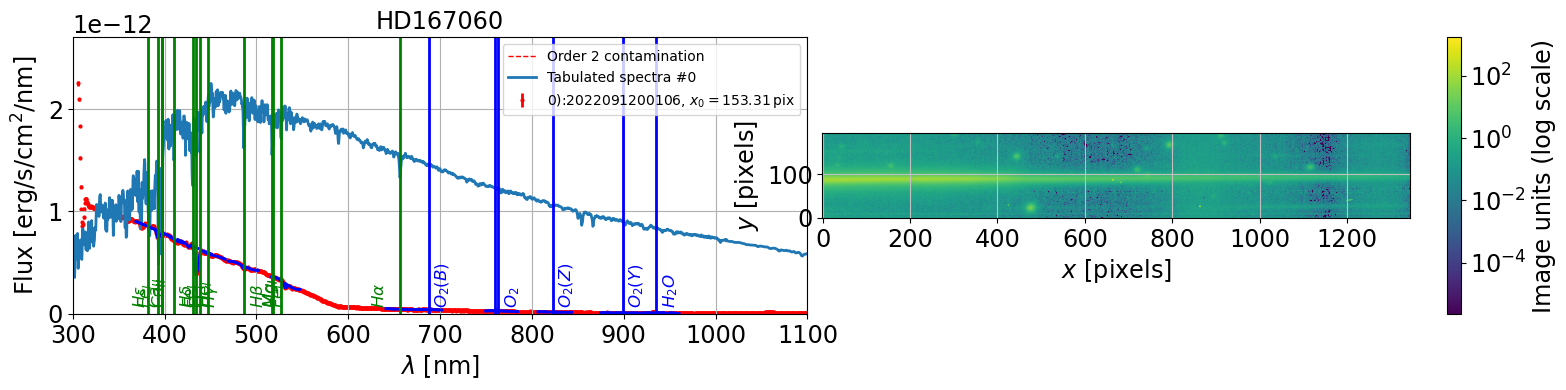

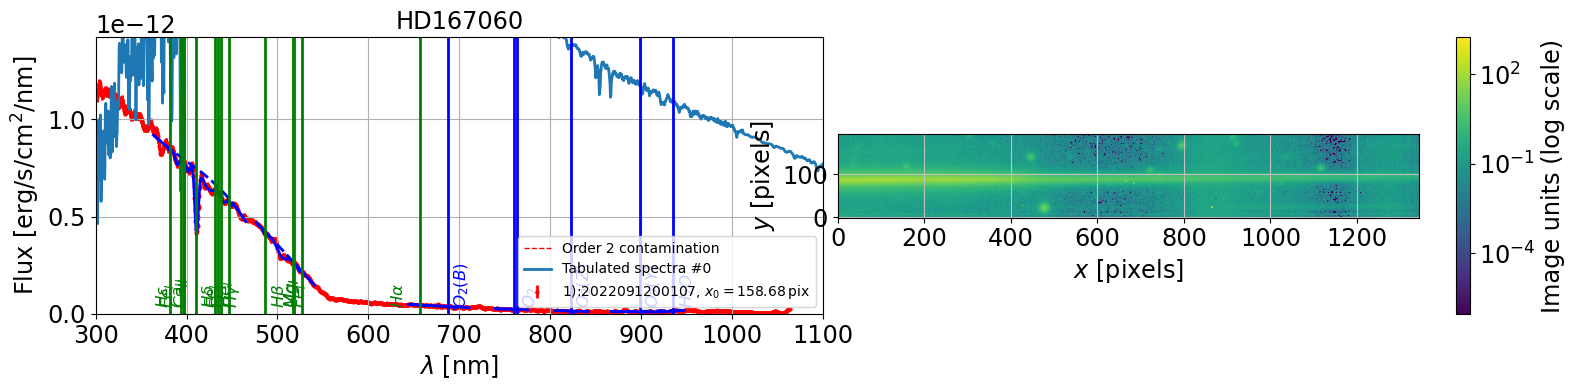

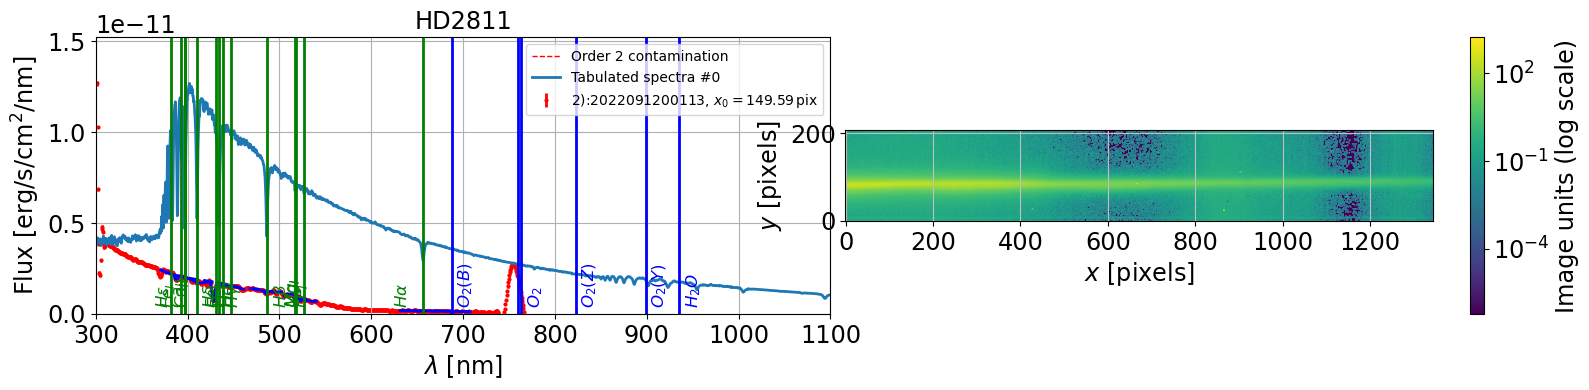

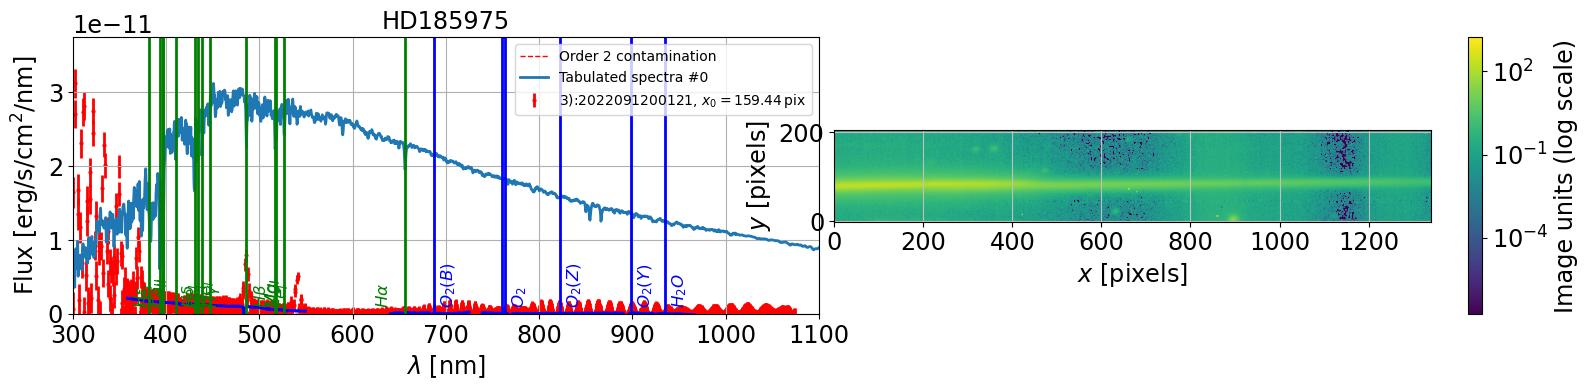

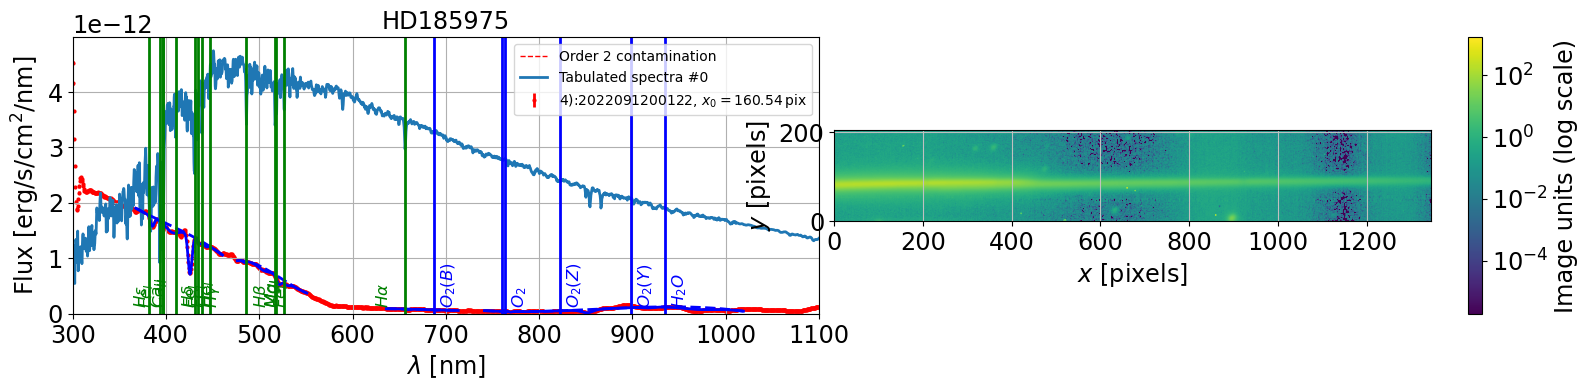

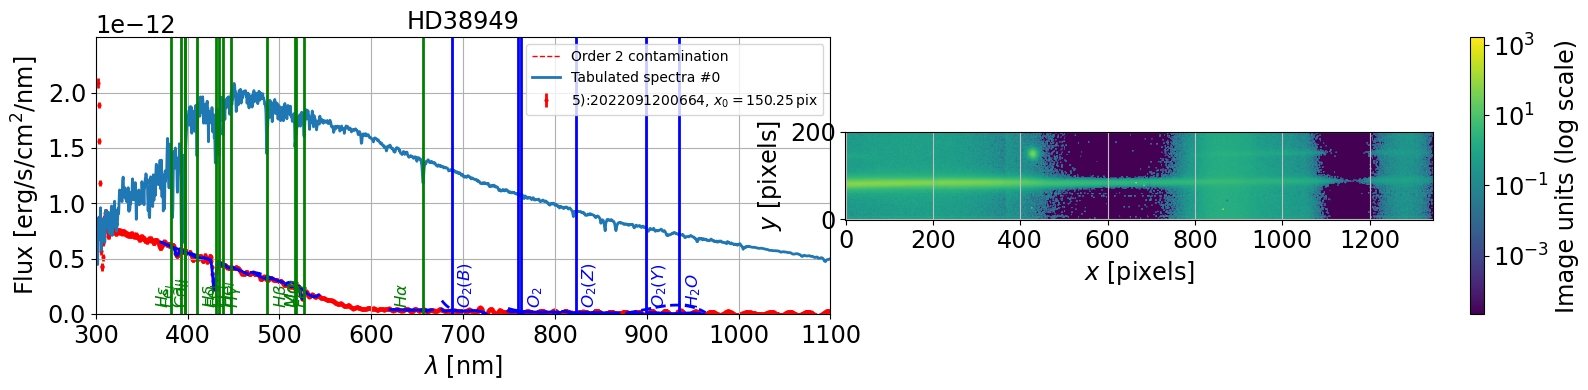

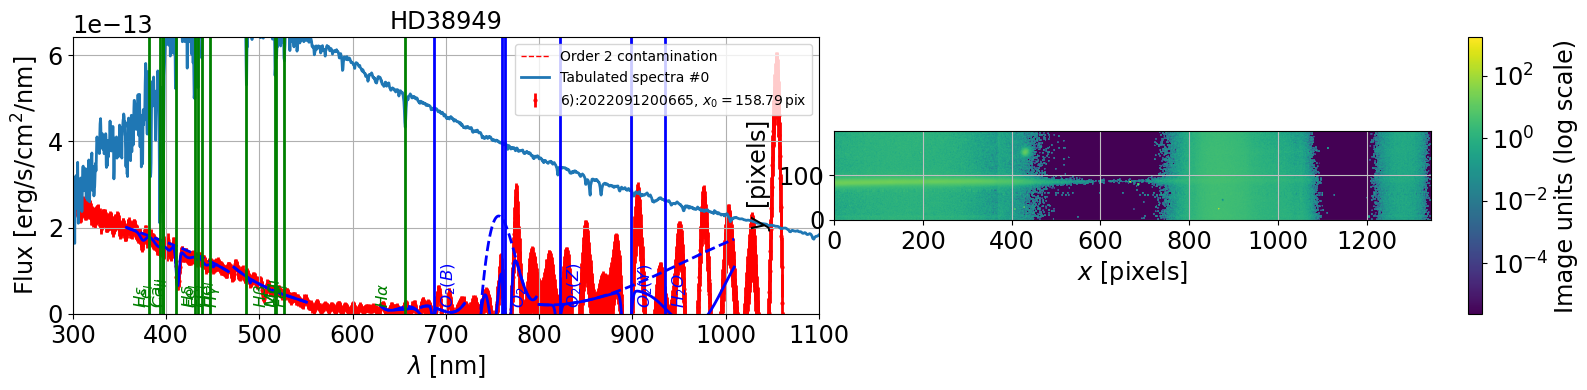

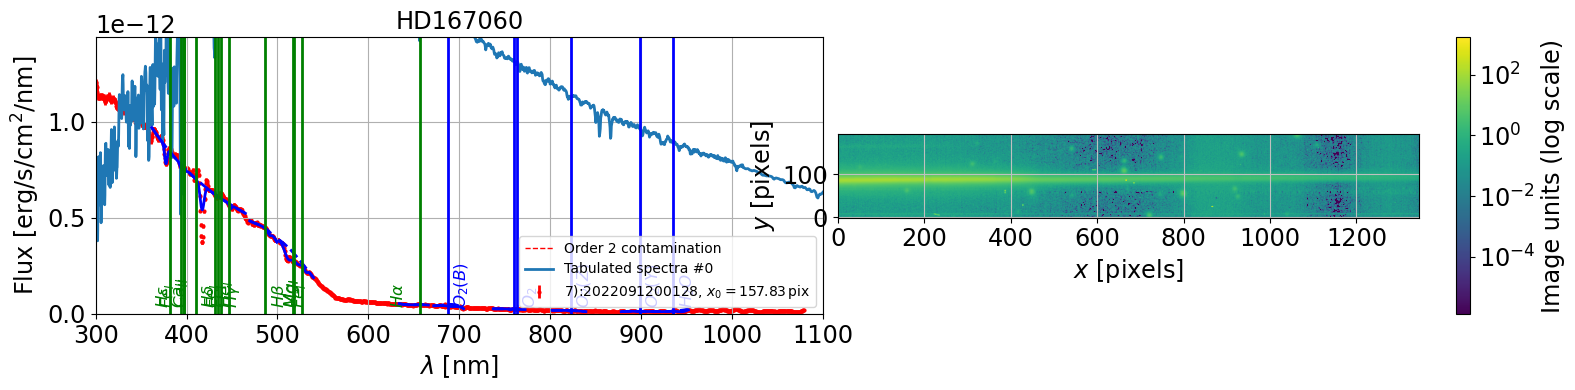

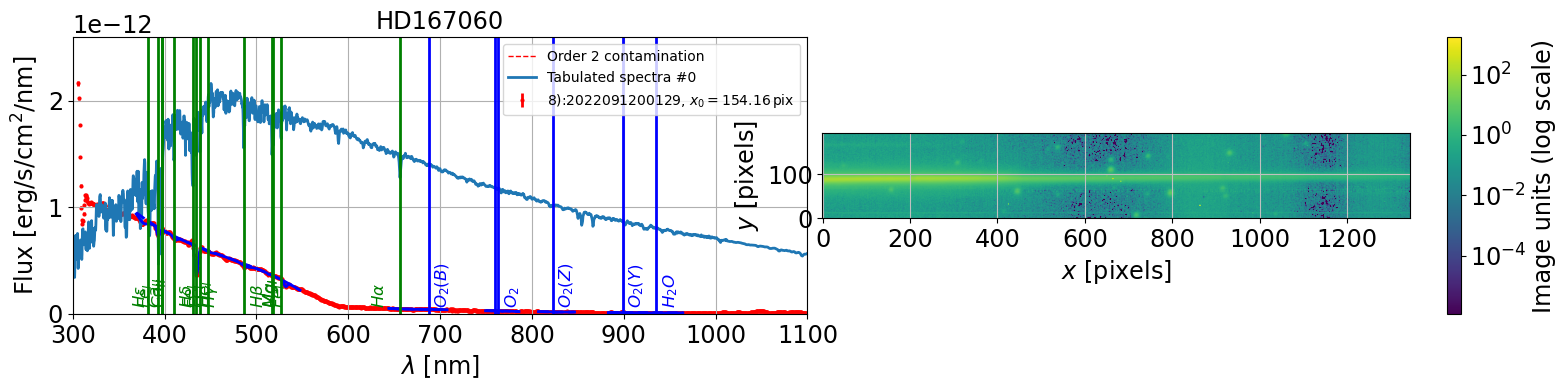

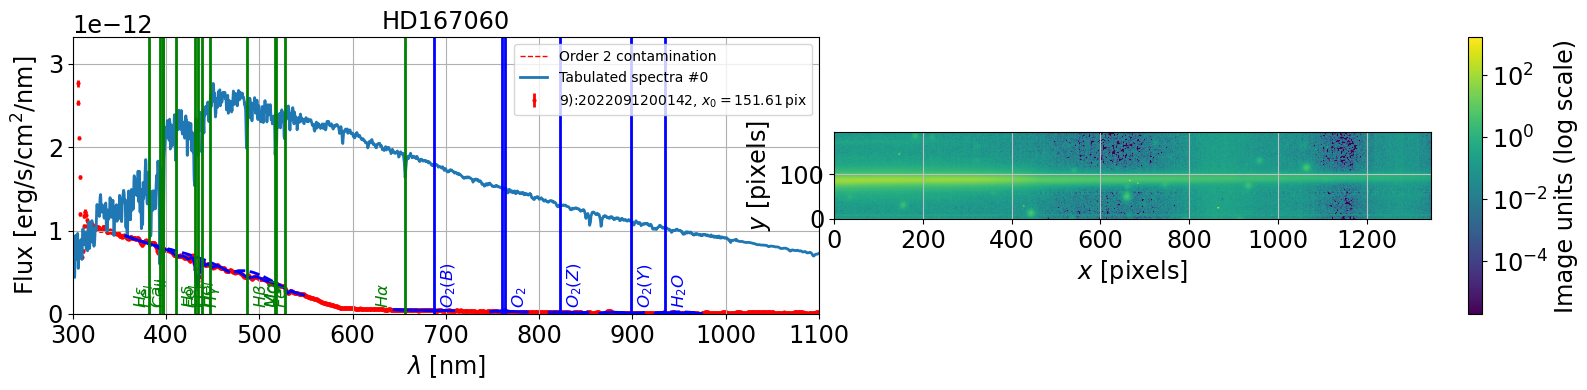

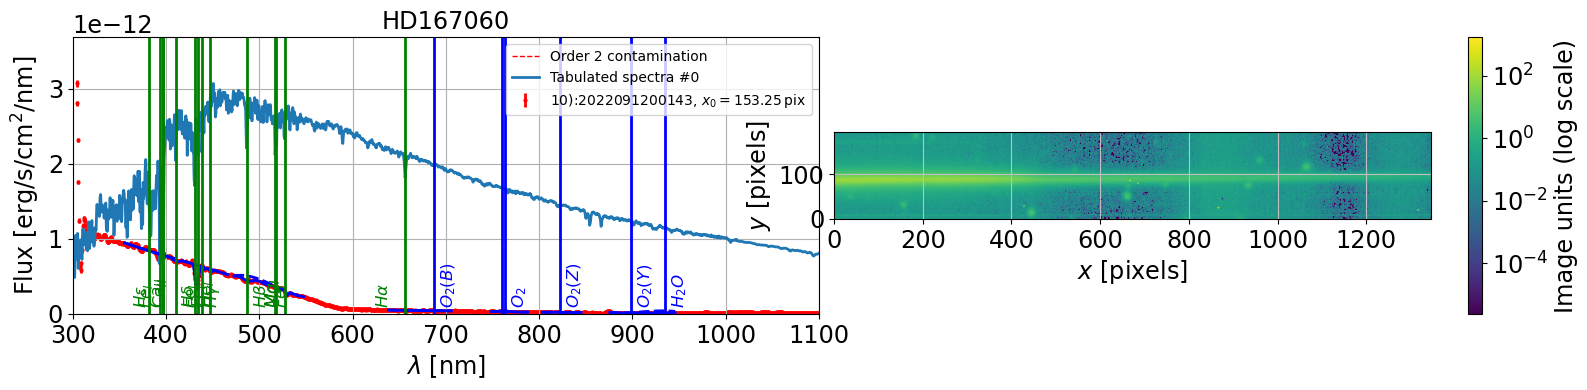

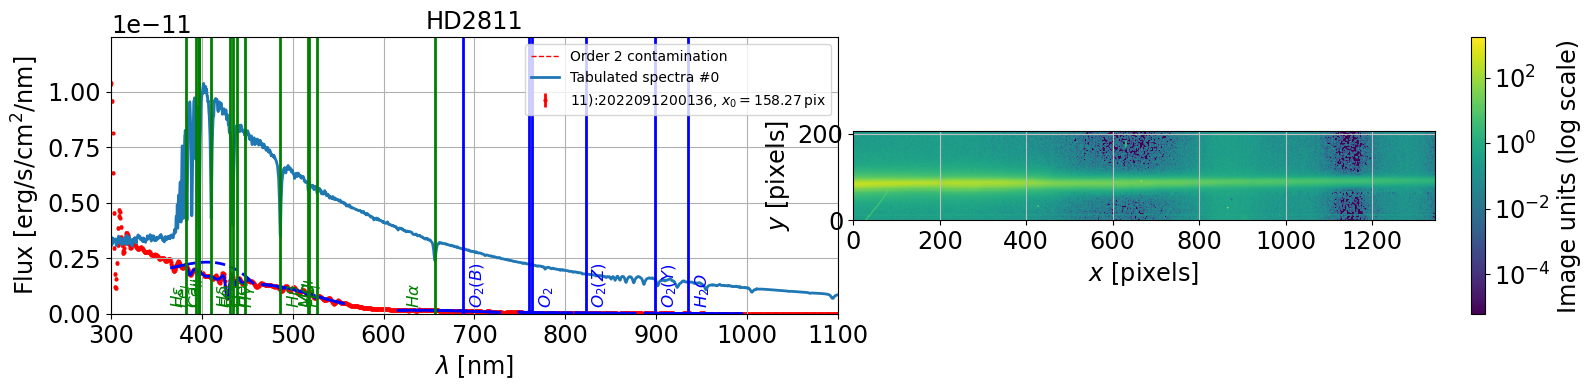

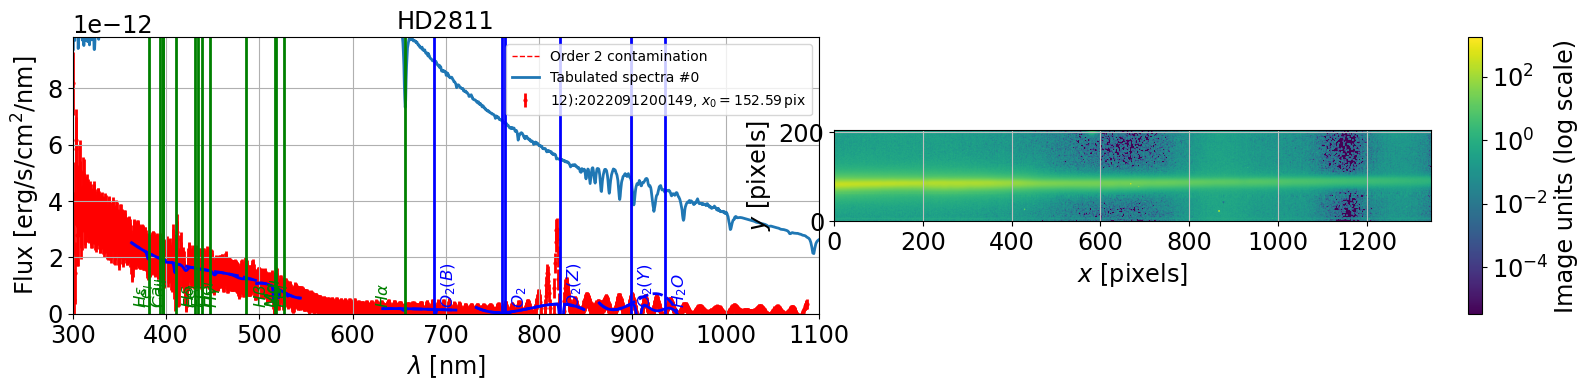

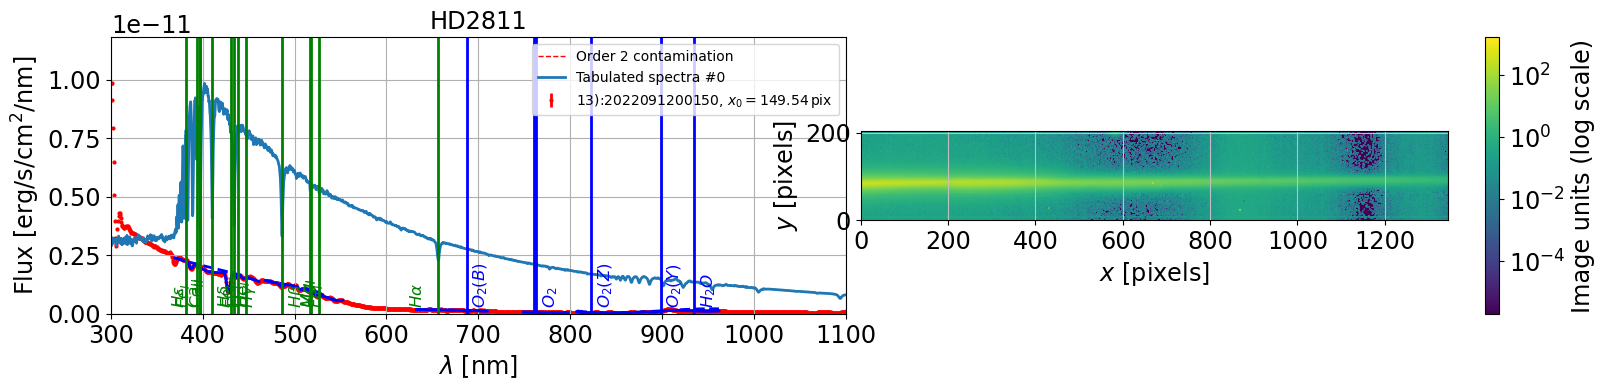

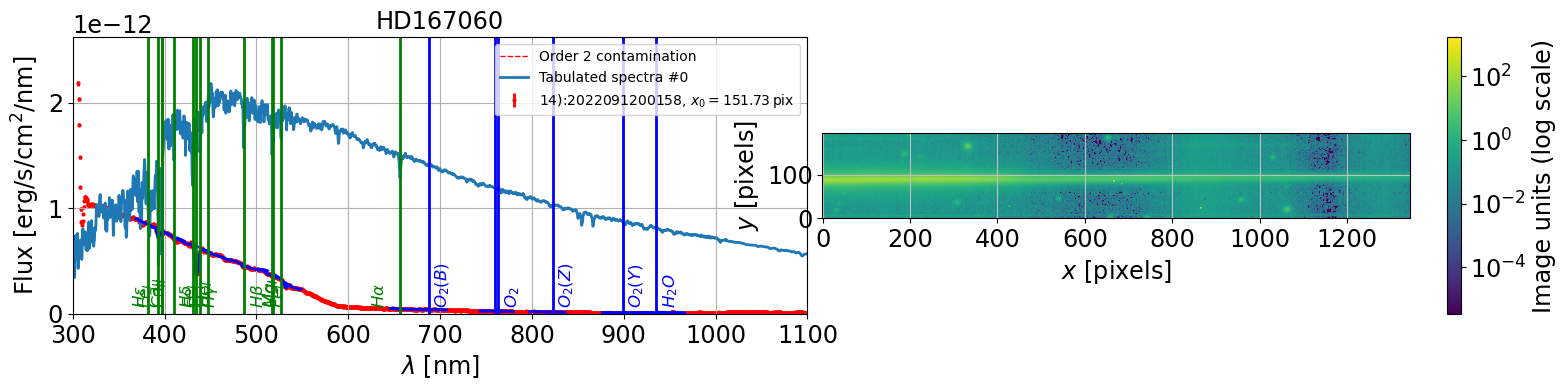

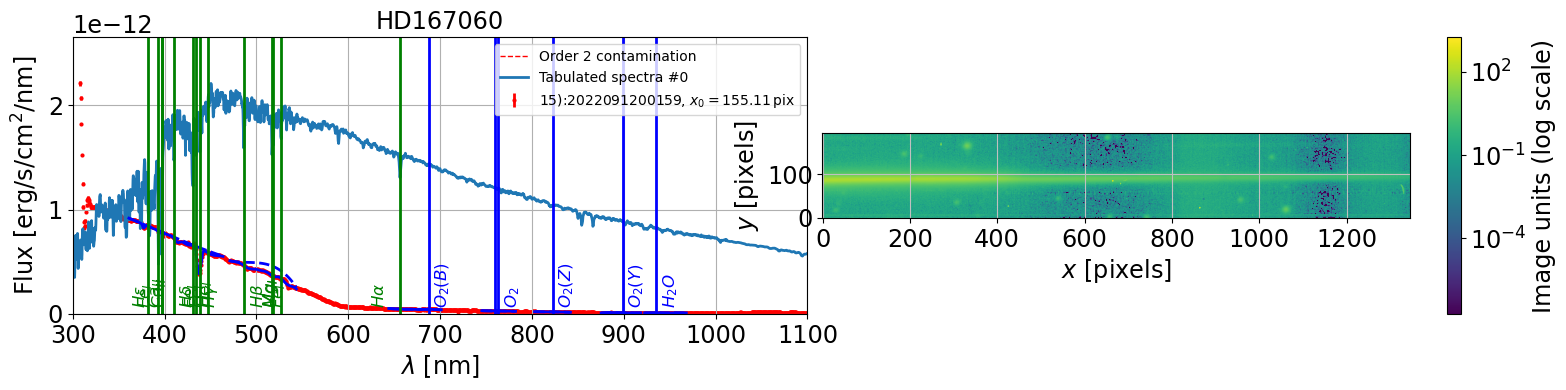

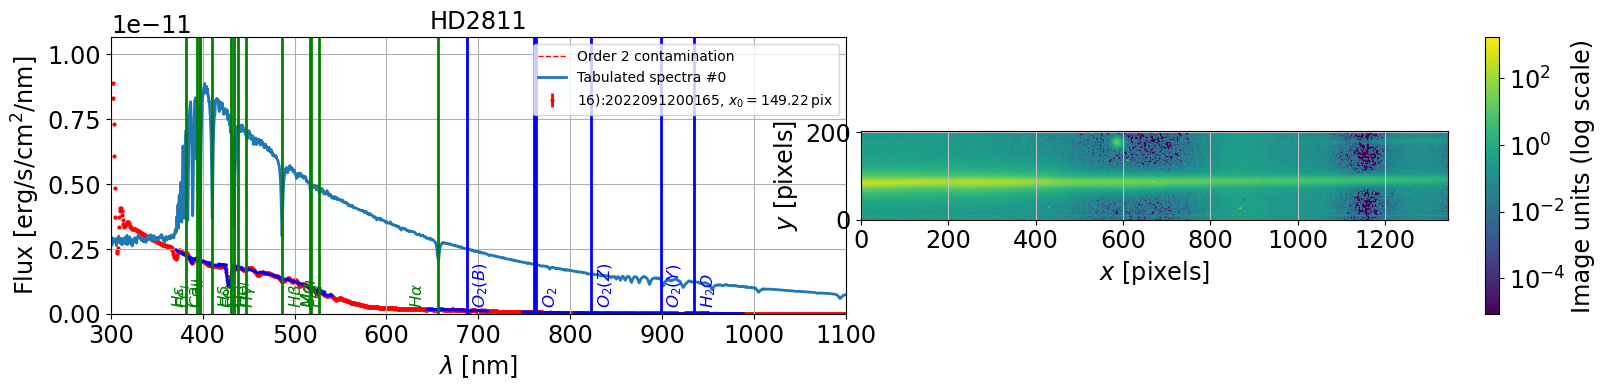

In [13]:
FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]


idx=0
for spec in all_spec:
    
    fig=plt.figure(figsize=(16,4))
    
    s=spec.spectrum
    label = str(idx) +"):" + str(all_exposures[idx])
    
    ax1 = fig.add_subplot(1, 2, 1)
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
        
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    idx+=1

In [14]:
infos

[[0, 'HD167060', '2022-09-13T01:21:26.405992547Z', 1.23373069063445, 0, 0, 0],
 [1, 'HD167060', '2022-09-13T01:22:09.211503001Z', 1.23459898457421, 0, 0, 0],
 [2, 'HD2811', '2022-09-13T01:26:05.830000089Z', 1.64107327445113, 0, 0, 0],
 [3, 'HD185975', '2022-09-13T01:30:53.808505359Z', 1.83763689501931, 0, 0, 0],
 [4, 'HD185975', '2022-09-13T01:31:36.699999655Z', 1.83759007842735, 0, 0, 0],
 [5, 'HD38949', '2022-09-13T07:20:48.532005656Z', 1.53029464277969, 0, 0, 0],
 [6, 'HD38949', '2022-09-13T07:21:31.436497321Z', 1.52558648716412, 0, 0, 0],
 [7, 'HD167060', '2022-09-13T01:35:04.715007846Z', 1.2515427915243, 0, 0, 0],
 [8, 'HD167060', '2022-09-13T01:35:47.634491333Z', 1.25254122046067, 0, 0, 0],
 [9, 'HD167060', '2022-09-13T01:44:25.829994129Z', 1.26521999048089, 0, 0, 0],
 [10, 'HD167060', '2022-09-13T01:45:08.680506562Z', 1.26631302194577, 0, 0, 0],
 [11, 'HD2811', '2022-09-13T01:40:27.842490594Z', 1.55163470914413, 0, 0, 0],
 [12, 'HD2811', '2022-09-13T01:49:08.654492450Z', 1.50341

In [15]:
all_lambdas

[array([ 306.22615262,  306.84467325,  307.46318543, ..., 1122.02148477,
        1122.61399952, 1123.20648472]),
 array([ 289.28539229,  289.87067665,  290.45595388, ..., 1062.64746987,
        1063.21066898, 1063.77384291]),
 array([ 301.67545016,  302.28130102,  302.88714389, ..., 1101.27859161,
        1101.85991579, 1102.44121208]),
 array([ 293.47743326,  294.06994632,  294.66245196, ..., 1073.22831923,
        1073.79804277, 1074.36774026]),
 array([ 299.21693513,  299.82287927,  300.42881549, ..., 1098.9967894 ,
        1099.57827958, 1100.15974193]),
 array([ 302.7254491 ,  303.33548433,  303.94551143, ..., 1108.2755885 ,
        1108.86060202, 1109.44558713]),
 array([ 289.90306515,  290.49223916,  291.08140591, ..., 1068.27370111,
        1068.84039678, 1069.4070668 ]),
 array([ 292.78991203,  293.38387863,  293.97783779, ..., 1077.85122597,
        1078.42212727, 1078.99300228]),
 array([ 306.1920905 ,  306.80985653,  307.42761414, ..., 1121.01790058,
        1121.60974168, 

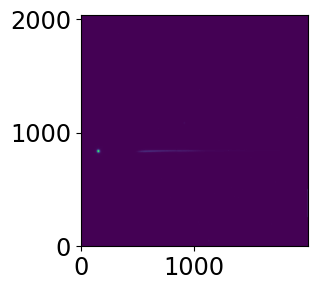

In [16]:
plt.imshow(spec.image.data,origin="lower")

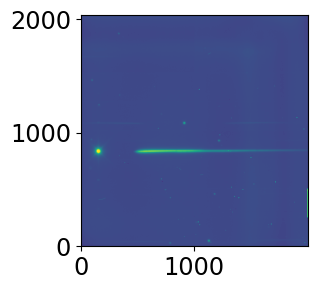

In [17]:
plt.imshow(spec.image.data-spec.image.data.min(),origin="lower",norm=LogNorm(vmin=1,vmax=1000))

# Generate info

In [18]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [19]:
df_infos.set_index('idx',inplace=True)

In [20]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [21]:
all_reftime=np.array(all_reftime)

In [22]:
df_infos["reftime"]=all_reftime

In [23]:
NN = len(df_infos)

In [24]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD167060,2022-09-13T01:21:26.405992547Z,1.233731,0,0,0,0.000000
1,HD167060,2022-09-13T01:22:09.211503001Z,1.234599,0,0,0,0.011890
2,HD2811,2022-09-13T01:26:05.830000089Z,1.641073,0,0,0,0.077618
3,HD185975,2022-09-13T01:30:53.808505359Z,1.837637,0,0,0,0.157612
4,HD185975,2022-09-13T01:31:36.699999655Z,1.837590,0,0,0,0.169526
5,HD38949,2022-09-13T07:20:48.532005656Z,1.530295,0,0,0,5.989479
6,HD38949,2022-09-13T07:21:31.436497321Z,1.525586,0,0,0,6.001397
7,HD167060,2022-09-13T01:35:04.715007846Z,1.251543,0,0,0,0.227308
8,HD167060,2022-09-13T01:35:47.634491333Z,1.252541,0,0,0,0.239230


### Save info file

In [25]:
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
df_infos.to_csv(summary_file)

## Main pickle file

In [26]:
#spec.image.target_pixcoords

In [27]:
header = spec.spectrum.header
header

SIMPLE  =                    T                                                  
TARGET  = 'HD2811  '           / name of the target in the image                
REDSHIFT= '0       '           / redshift of the target                         
GRATING = 'holo4_003'          / name of the disperser                          
ROTANGLE=  -0.9697790008790278 / [deg] angle of the dispersion axis             
D2CCD   =   -210.6366678754676 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
PARANGLE=   -93.04511973485526 / parallactic angle in degree                    
TARGETX =    149.2206914042234 / target position on X axis                      
TARGETY =    851.3004438012375 / target position on Y axis                      
THETAFIT=   0.9056171482827036 / [deg] [USED] rotation angle from the Hessian an
THETAINT=  -0.3490732249159116 / [deg] rotation angle interp from disperser scan
LBDA_REF=    439.43750595062

In [28]:


all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)
all_errors=np.zeros(NN)


for idx in range(NN):
    
    header = all_spec[idx].spectrum.header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    try :
        rebin=header["REBIN"]
    except KeyError as e:
        rebin=2
        all_errors[idx]=1
        print(f"KeyError exception for spec {idx}: " + str(e) + f" ! ==> force rebin = {rebin}")
        
        
        
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    


KeyError exception for spec 0: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 1: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 2: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 4: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 8: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 10: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 11: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 12: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 13: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 14: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 16: "Keyword 'REBIN' not found." ! ==> force rebin = 2


## Write pickle file

In [29]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],    
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],  
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[all_exposures[idx]]=thedata


In [30]:
#all_out_data

In [31]:
pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configmode}-oga.pickle'

In [32]:
with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)

In [33]:
pkl_infilename=pkl_outfilename

In [34]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [35]:
# Get first value of dictionary
next(iter(content.items()))

(2022091200106,
 {'number': 106.0,
  'object': 'HD167060',
  'dateobs': '2022-09-13T01:21:26.405992547Z',
  'refhour': 0.0,
  'airmass': 1.23373069063445,
  'pressure': 0,
  'temperature': 0,
  'humidity': 0,
  'targetx_pix': 306.62388488550926,
  'targety_pix': 1696.914026652214,
  'rotangle': -0.48715670229940256,
  'd2ccd': -206.59696970922928,
  'error': 1.0,
  'all_lambdas': array([ 306.22615262,  306.84467325,  307.46318543, ..., 1122.02148477,
         1122.61399952, 1123.20648472]),
  'all_fluxes': array([2.25014570e-12, 2.09487691e-12, 1.83338836e-12, ...,
         5.65448238e-15, 5.44256529e-15, 5.22879474e-15]),
  'all_fluxes_err': array([2.31772563e-14, 1.70096329e-14, 1.25347670e-14, ...,
         3.46694684e-15, 3.81315279e-15, 4.03491747e-15]),
  'all_lambdas_order2': array([ 306.1943228 ,  306.81284386,  307.43135648, ..., 1121.99099266,
         1122.58350893, 1123.17599566]),
  'all_fluxes_order2': array([7.00041095e+03, 6.38869150e+03, 5.48411644e+03, ...,
         5